In [21]:
import numpy as np
import os
import glob
import pandas as pd
from sklearn.manifold import Isomap,\
                            LocallyLinearEmbedding,\
                            SpectralEmbedding,\
                            TSNE,\
                            locally_linear_embedding
from umap import UMAP
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import ParameterGrid

from joblib import Parallel, delayed
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from utils import transform, calculate_Q_metrics, KNN_MAE
from IPython.display import clear_output
N_CPU = cpu_count()

import warnings
warnings.simplefilter("ignore")

# Load data

In [22]:
intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict.npy', allow_pickle=True).item()

data_orig = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data_processed/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values

data_pca = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')
        
embeddings_root = 'results/embeddings'
embeddings_params_root = 'results/embeddings_params/'

os.makedirs(embeddings_root, exist_ok=True)
os.makedirs(embeddings_params_root, exist_ok=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]


In [23]:
# # uncomment to use synthetic data

# intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict_synthetic.npy', allow_pickle=True).item()

# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')

    
# embeddings_root = 'results/embeddings_synthetic'
# embeddings_params_root = 'results/embeddings_params_synthetic/'

# os.makedirs(embeddings_root, exist_ok=True)
# os.makedirs(embeddings_params_root, exist_ok=True)

# Hyperparameters Grid Search

In [24]:
# heavily slowes the hyperparameter search,
# but allows to estimate Q-metrics for each combination
include_Q_scores = False

knn_mae_scorer = lambda *args: KNN_MAE(*args, averaging='median', weights='distance', n_neighbors=5)

if include_Q_scores:
    scorer = lambda *args: (calculate_Q_metrics(*args) + [knn_mae_scorer(*args)])
else:
    scorer = knn_mae_scorer

In [112]:
baseline_errors = {}
for label, X in tqdm((data_pca.items())):
    baseline_errors[label] = knn_mae_scorer(X,X)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.45it/s]


In [106]:
mf_models = {
    
            'isomap':{'class':Isomap, 'params_grid':{'n_neighbors':[5,10,15,25],
                                                      'p':[1,2],
                                                      'metric':['minkowski'],
                                                      'n_jobs':[1]
                                                     }
                      },
    
    
            'spectral':{'class':SpectralEmbedding, 'params_grid':{'affinity':['nearest_neighbors', 'rbf'],
                                                                   'n_neighbors':[5,10,15,25],
                                                                   'gamma':[1e-4, 1e-3, 1e-2, None, 1e-1],
                                                                   'random_state':[42],
                                                                   'n_jobs':[1]
                                                                  }
                        },
    

            'lle':{'class':LocallyLinearEmbedding, 'params_grid':{'method':['ltsa', 'standard'],
                                                       'reg':[0.0001, 0.001, 0.01],
                                                       'n_neighbors':[10,15,25,50],
                                                       'random_state':[42],
                                                       'n_jobs':[1],
                                                       'eigen_solver':['dense']
                                                     }
                  },
    
            'umap':{'class':UMAP, 'params_grid':{'n_neighbors':[5,10,15,25,50],
                                                 'min_dist':[0.05, 0.1, 0.25, 0.5],
                                                 'learning_rate':[0.1, 1],
                                                 'random_state':[42],
                                                 'metric':['manhattan'],
                                                 'n_epochs':[2000],
                                                 'n_jobs':[1]
                                                }
                   },
    
            'tsne':{'class':TSNE, 'params_grid':{'perplexity':[5,10,15,25,50],
                                                 'random_state':[42],
                                                 'early_exaggeration':[5,10,25],
                                                 'init':['pca'],
                                                 'metric':['manhattan'],
                                                 'method':['exact'],
                                                 'n_jobs':[1],
                                                 'n_iter':[2000],
                                                 'n_iter_without_progress':[100]
                                                 }
                   } 
            }

# iterate over the models
for mf_type, model in mf_models.items():    
    # iterate over the datasets
    for i,(label, X) in tqdm(enumerate(data_pca.items())):
        
        results = {}
        results_path = os.path.join(embeddings_params_root,\
                                    f'pca_{mf_type}_{label}')
        
        if os.path.isfile(results_path + '.npy'):
            print(f'{results_path} exists, skipping...')
            continue

        dim = intrinsic_dims[label]
        print('Calculating...', label, 'Method:', mf_type, 'Intrinsic dim:', dim)

        model_class = model['class']
        model_param_grid = model['params_grid']
        
        try:
            scores = Parallel(n_jobs=-1)(delayed(transform)(model_class,
                                                            X, 
                                                            dim,
                                                            model_params,
                                                            scorer) \
                              for model_params in list(ParameterGrid(model_param_grid)))  
            
            results['scores'] = scores
            results['params'] = model_param_grid
            np.save(results_path, results)
            
        except Exception as e:
            print(f'Failed to estimate perameters for {mf_type}, {label}:', e)
            continue
            
clear_output()

# Visualization

In [107]:
all_metrics = defaultdict(dict)

for metrics_results_name in \
                   filter(lambda x: 'pca' in x, os.listdir(embeddings_params_root)):
    
    mf_type, dataset_name, tax_name = metrics_results_name.split('.')[0].split('_')[-3:]
    label = '_'.join([dataset_name, tax_name])
    all_metrics[mf_type][label] = np.load(os.path.join(embeddings_params_root, 
                                          metrics_results_name), \
                                          allow_pickle=True).item()

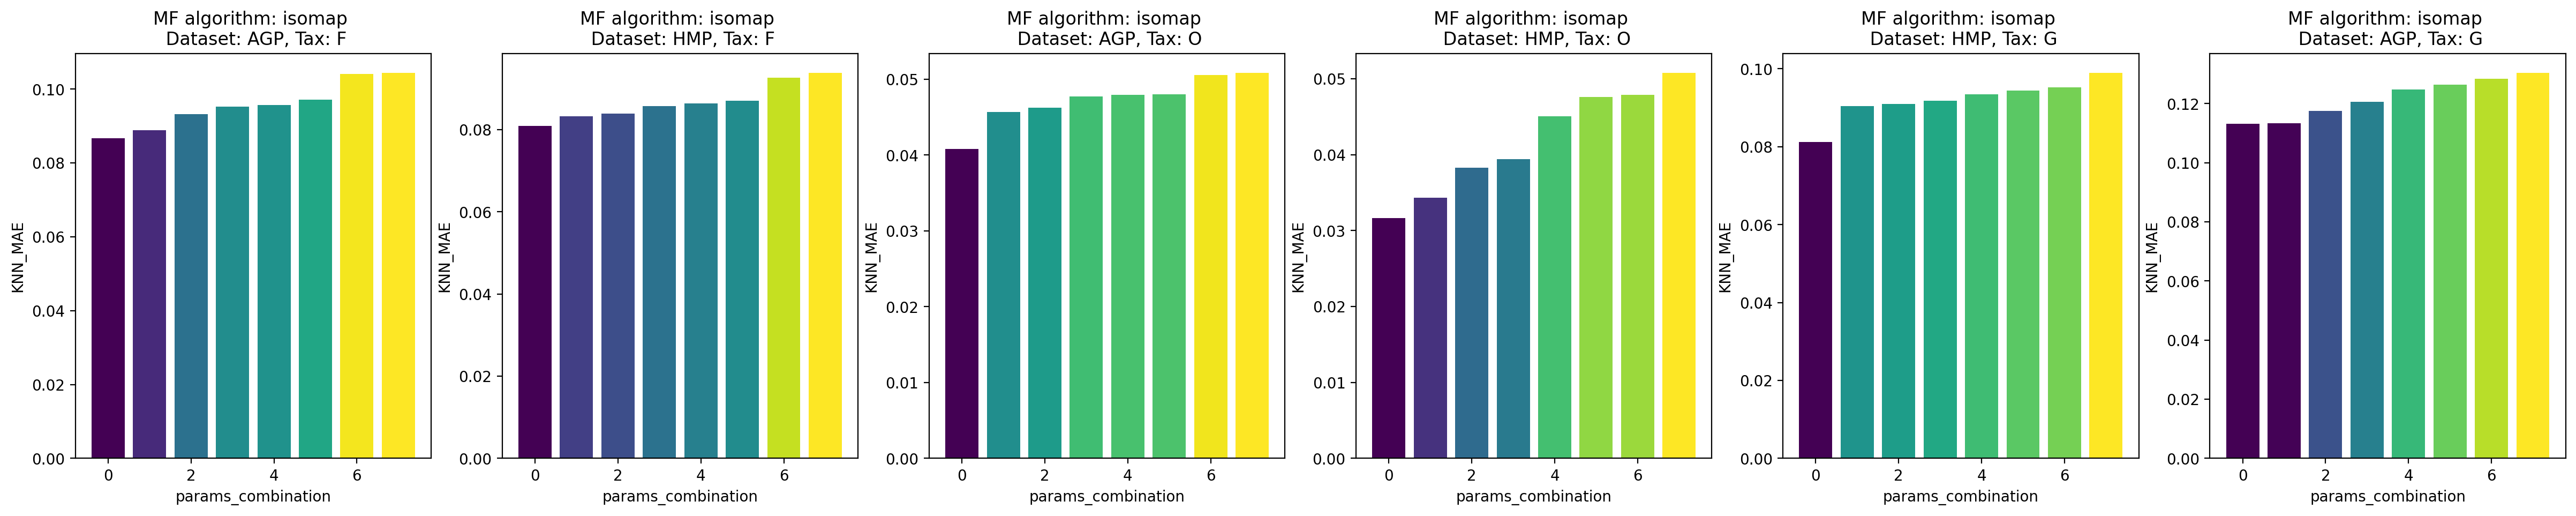

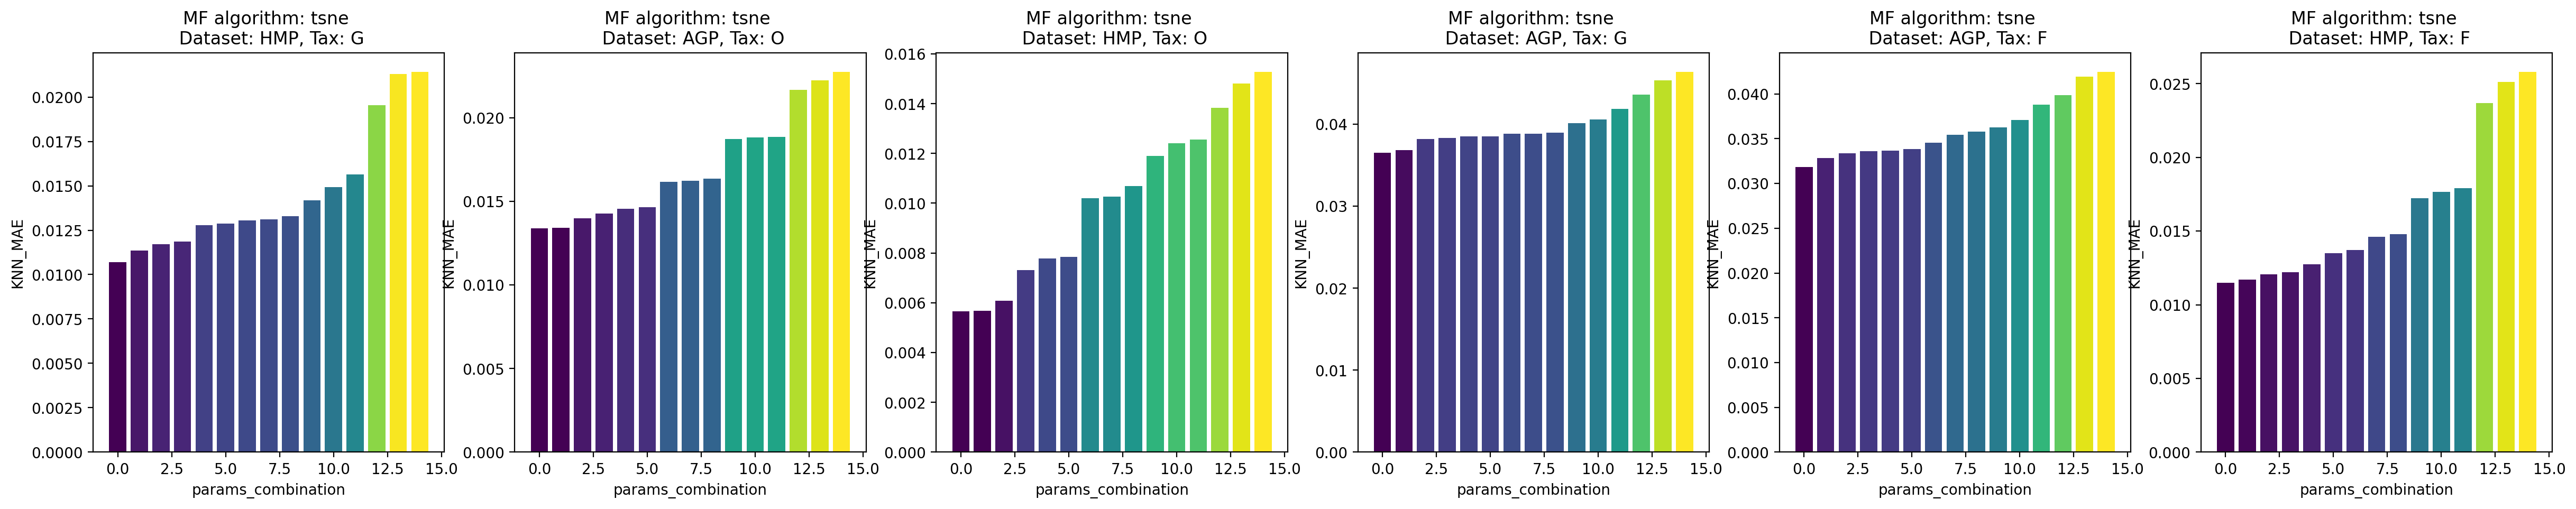

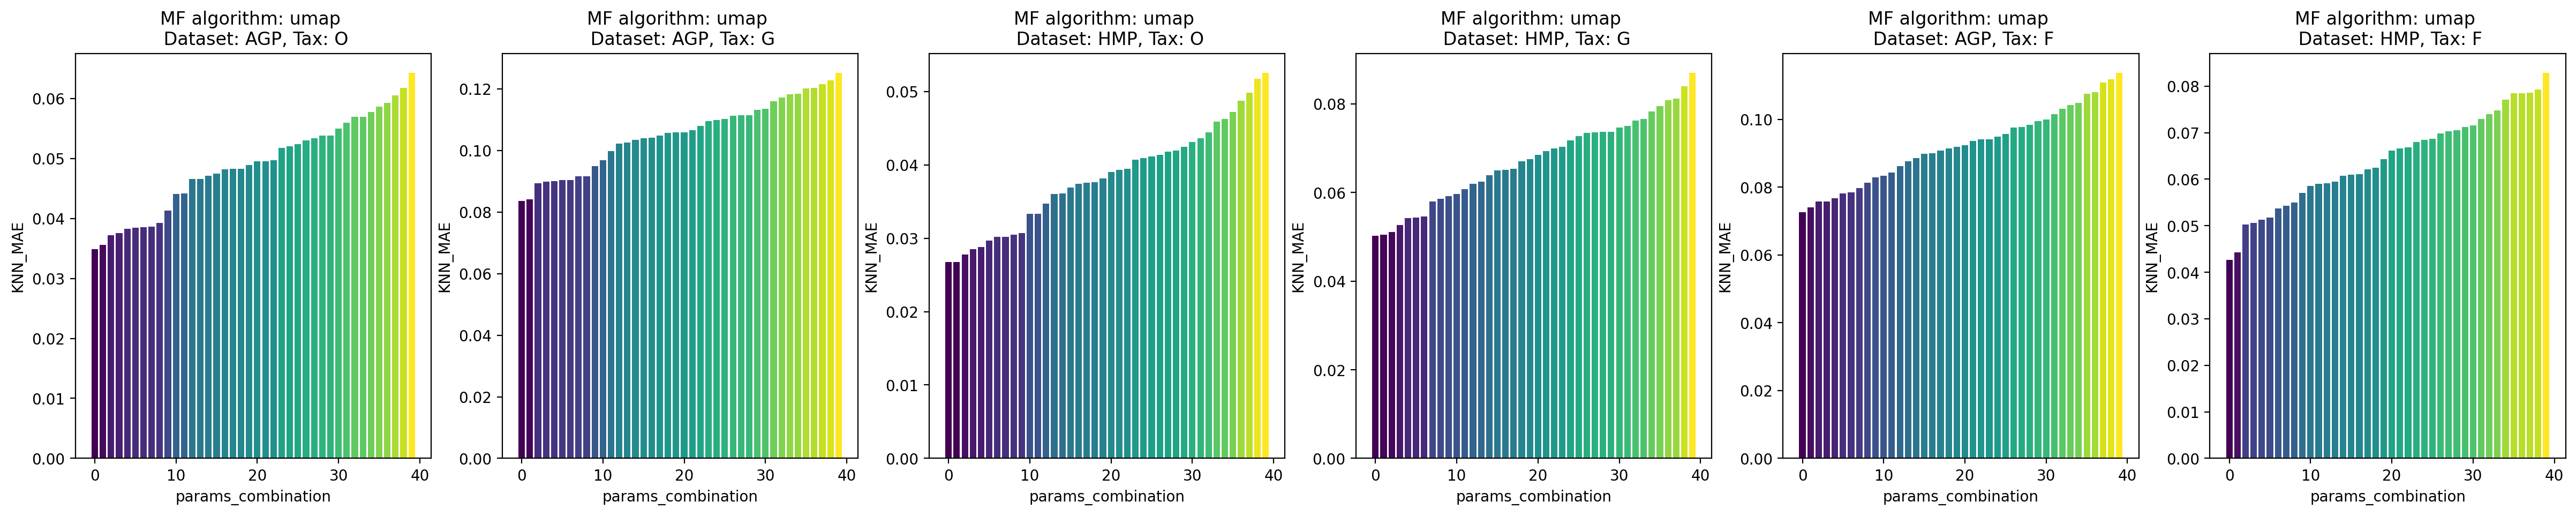

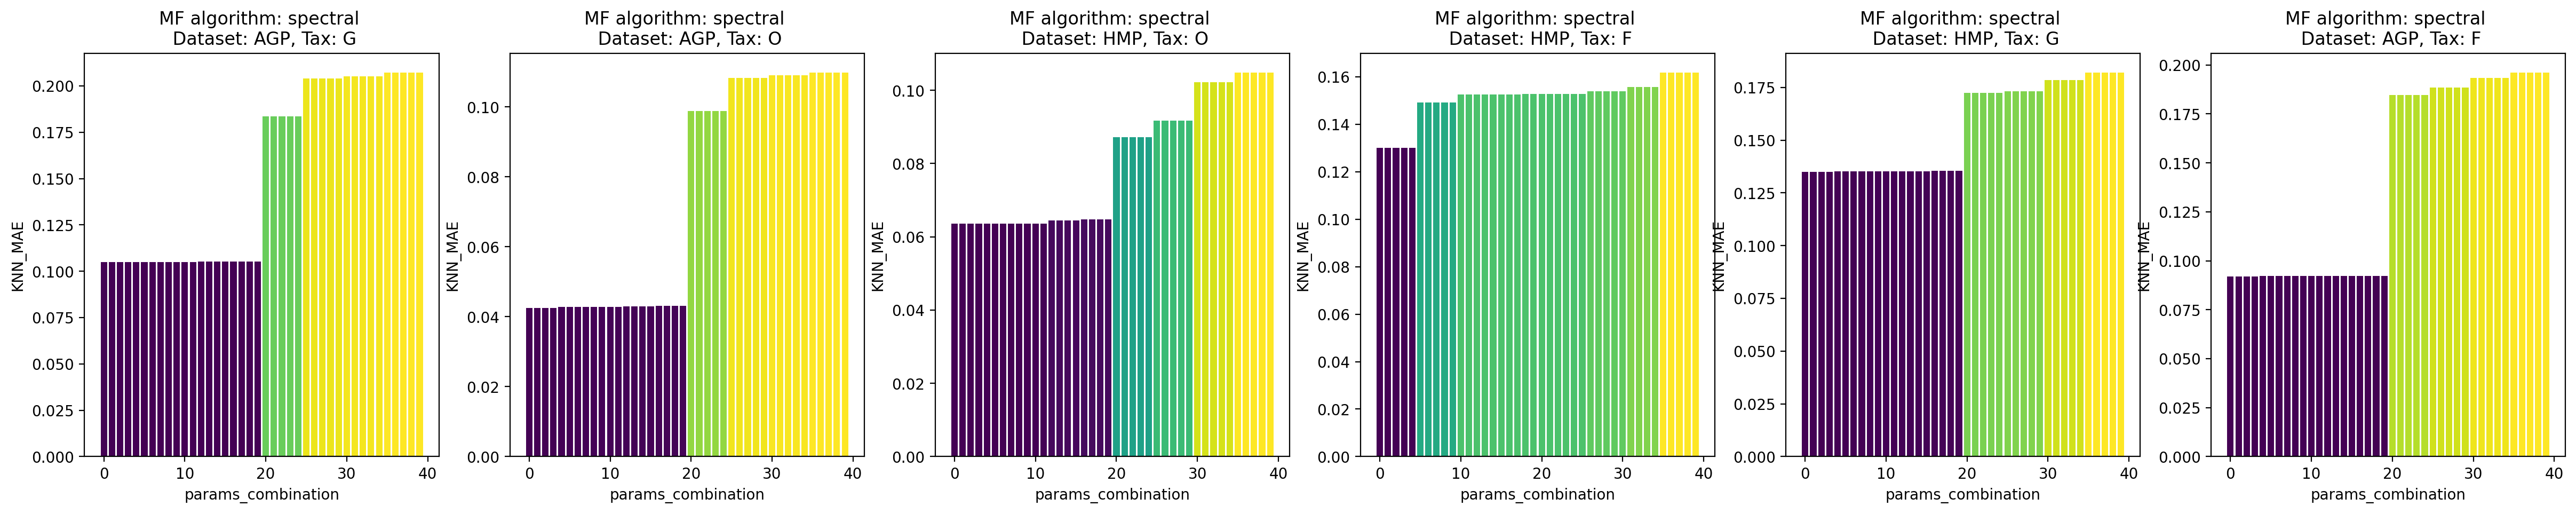

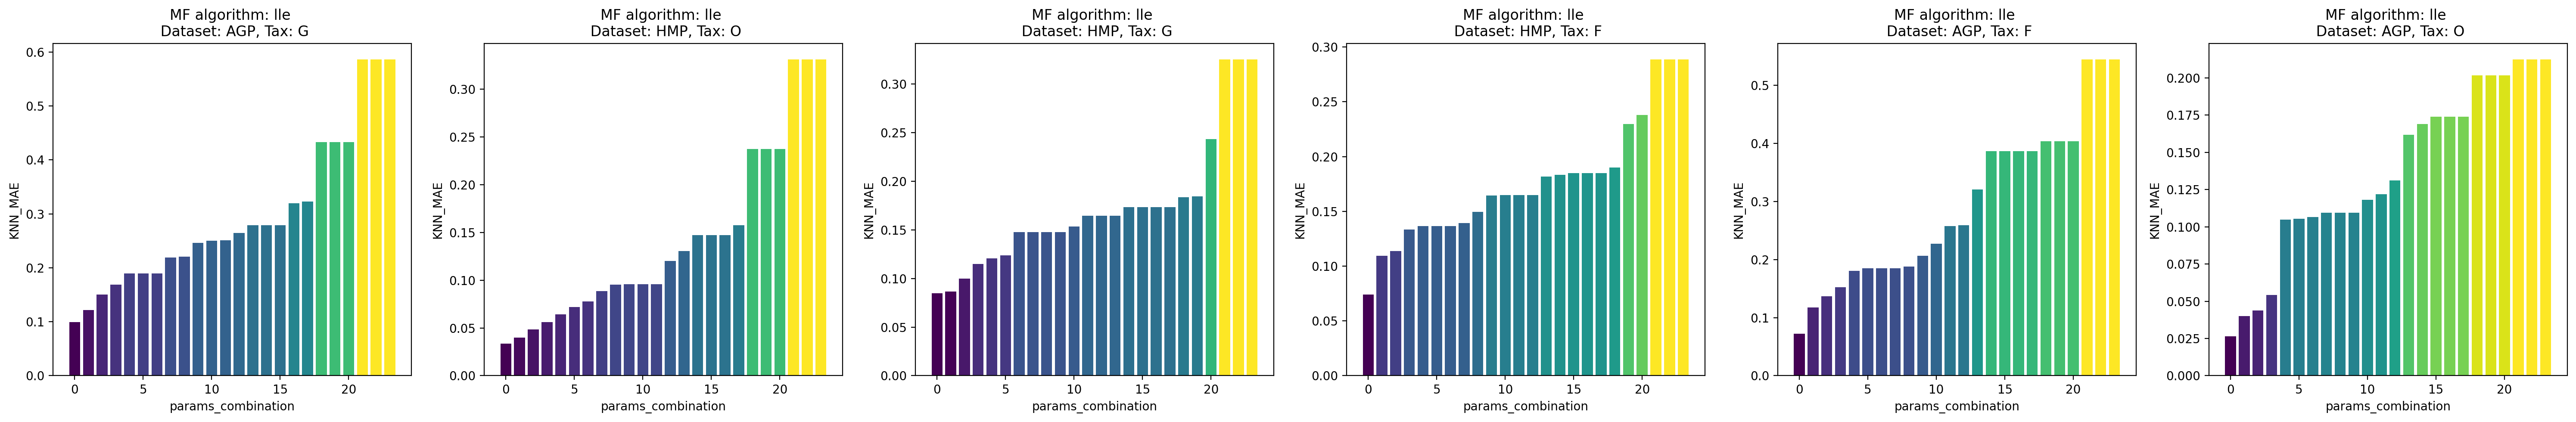

In [130]:
best_params = defaultdict(dict)

my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

for mf_type, mf_metrics in all_metrics.items():
    mf_metrics_items = mf_metrics.items()
    
    fig, axes = plt.subplots(nrows=1, ncols = len(mf_metrics_items), figsize=(len(mf_metrics_items)*5,5), dpi=200)
    
    for i,(label, mf_label_metrics) in enumerate(mf_metrics_items):
        
        scores = np.array(mf_label_metrics['scores'])
        params = list(ParameterGrid(mf_label_metrics['params']))
        dataset_name = label.split('_')[0]
        tax_name = label.split('_')[-1]
        
        if include_Q_scores:
            maes = scores[:,-1]
        else:
            maes = scores
            
        mae_argmin = maes.argmin()
        
        best_params[label][mf_type] = params[mae_argmin] 
        
        # scatterplot with Q-metrics
        if include_Q_scores:
            sc = axes[i].scatter(scores[:,0], scores[:,1], c=scores[:,2])
            axes[i].set_xlabel('Q_loc')
            axes[i].set_ylabel('Q_glob')
        
        else:
            scores_rel = scores - baseline_errors[label]
            scores_rel = sorted(scores_rel)
            axes[i].bar(np.arange(len(scores_rel)), scores_rel, color=my_cmap(rescale(scores_rel)))
            axes[i].set_xlabel('params_combination')
            axes[i].set_ylabel('KNN_MAE')
            
        axes[i].set_title(f'MF algorithm: {mf_type} \n Dataset: {dataset_name}, Tax: {tax_name.capitalize()}')
        
            
    if include_Q_scores:
        fig.colorbar(sc, orientation='vertical')
plt.tight_layout()        
plt.show()

# Train final embeddings

In [ ]:
methods_dict = {'tsne':TSNE,
                'lle':LocallyLinearEmbedding,
                'umap':UMAP,
                'isomap':Isomap,
                'spectral':SpectralEmbedding
               }


Q_mae_scorer = lambda *args: (calculate_Q_metrics(*args) + [knn_mae_scorer(*args)])

PERCENTILE = 95
DATA_PERCENT_THRESHOLD = 0.9

for label, best_params_ in tqdm(best_params.items()):
    
    X_pca = data_pca[label]
    X_orig  = data_orig[label]
    intdim = intrinsic_dims[label]

    for method_name, params_dict in best_params_.items():
        
        embedding_path = os.path.join(embeddings_root, f'{label}_{method_name}')

        if os.path.isfile(embedding_path + '.npy'):
            print(embedding_path, f'Embedding for {method_name}, {label} exists! Skipping...') 
        else:
            print(embedding_path, f'Calculating {method_name} for {label}...')  

            params_dict['n_jobs'] = -1

            Z = methods_dict[method_name](n_components=intdim, **params_dict).fit_transform(X_pca)
            d = {'Z':Z}

            mae = knn_mae_scorer(X_orig, Z)
            baseline_mae = knn_mae_scorer(X_orig, X_orig)
            Q_loc, Q_glob = calculate_Q_metrics(X_orig, Z)
            
            d['Q_loc'] = Q_loc
            d['Q_glob'] = Q_glob
            d['knn_mae'] = mae
            d['knn_mae_base'] = baseline_mae 
            
            
            N = X_orig.shape[0]
            X_ = X_orig.copy()
            Z_ = Z.copy() 

            inliers_indexes = np.arange(N)
            # iteratively choosing subset of high-mae outliers
            maxiter = 20
            for _ in range(maxiter):
                scoring_list = KNN_MAE(X_, Z_, averaging=None, weights='distance', n_neighbors=5) 
                q = np.percentile(scoring_list, PERCENTILE)
                mask = scoring_list < q
                if mask.sum()/N < DATA_PERCENT_THRESHOLD:
                    break
                X_ = X_[mask]
                Z_ = Z_[mask]
                inliers_indexes = inliers_indexes[mask]

            outliers_indexes = set(np.arange(N)) - set(inliers_indexes)
            # cast set to np.array
            outliers_indexes = np.array(list(outliers_indexes))
            
            mae_ = knn_mae_scorer(X_, Z_)
            baseline_mae_ = knn_mae_scorer(X_, X_)
            Q_loc_, Q_glob_ = calculate_Q_metrics(X_, Z_)

            d['inliers_indexes_mae'] = inliers_indexes
            d['outliers_indexes_mae'] = outliers_indexes
            d['X_'] = X_
            d['Z_'] = Z_ # final embedding
            d['Q_loc_'] = Q_loc_ 
            d['Q_glob_'] = Q_glob_ 
            d['knn_mae_'] = mae_ # final mae
            d['knn_mae_base_'] = baseline_mae_ 

            np.save(embedding_path, d)   
            
        print(f'Initial metrics: mae={mae}, Q_loc={Q_loc}, Q_glob={Q_glob}, baseline_error: {baseline_mae}') 
        print(f'After removing outliers: mae={mae_}, Q_loc={Q_loc_}, Q_glob={Q_glob_}, baseline_error: {baseline_mae_}')
        print('-----------------------------------------------------------','\n')


  0%|                                                                                                                                                  | 0/6 [00:00<?, ?it/s]

results/embeddings/AGP_f_isomap Calculating isomap for AGP_f...
Initial metrics: mae=0.2344212301793327, Q_loc=0.6384815405628331, Q_glob=0.8776597248394081, baseline_error: 0.1815545583179468
After removing outliers: mae=0.22052738599824134, Q_loc=0.6566599406104342, Q_glob=0.8873078657711884, baseline_error: 0.17151375628589532
----------------------------------------------------------- 

results/embeddings/AGP_f_tsne Calculating tsne for AGP_f...
